In [1]:
from astropy import units as u
import numpy as np
from poliastro.bodies import Moon
from poliastro.twobody import Orbit


inclination = 102.6 << u.deg # [deg] inclination
peri_alt = 59.9 << u.km # [km] Periapsis Alt
apo_alt = 6016.1 << u.km # [km] Apoapsis Alt
raan = -132.0 << u.deg #[deg] Long of Ascending Node 
arg_peri = 146.6 << u.deg # [deg] Argument of Periapsis
nu = 0 << u.deg # [deg] True anomaly
orbit_period =  8.2 # [hr] Orbital Period
moon_mu = 4902.8001 << (u.km**3)/(u.s**2) # [km^3/s^2]
#moon_mu = 1.62 << (u.m / u.s**2) # [m/s^2]
moon_radius = 1737.4 << u.km # [km] 

Ra = apo_alt + moon_radius # Radius at Apoapsis
Rp = peri_alt + moon_radius # Radius at Periapsis
a = (Ra + Rp) / 2 << u.km # Semi-major axis [km]

ecc = (Ra - Rp) / (Ra + Rp) << u.one

orb = Orbit.from_classical(Moon, a, ecc, inclination, raan, arg_peri, nu)


orb.period.to(u.hour)




<Quantity 8.2256442 h>

In [2]:
print(ecc)

0.6236336223143611


In [3]:
from poliastro.plotting import OrbitPlotter3D


plot_obj = OrbitPlotter3D()

plot_obj.plot(orb)

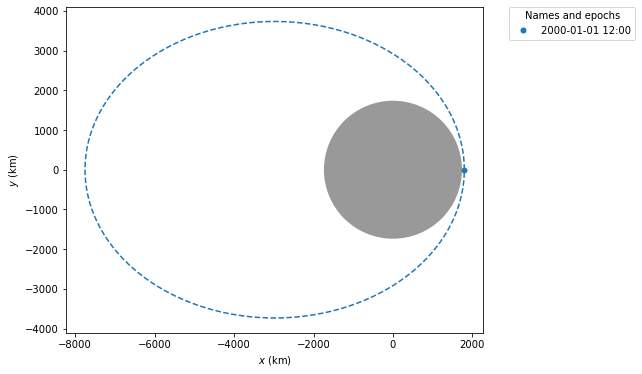

In [4]:
orb.plot()

In [5]:
orb.v

<Quantity [ 1.06001638,  0.60447931, -1.71465176] km / s>

In [6]:
orb.r

<Quantity [ 843.62154762, 1259.48406671,  965.55158334] km>

In [7]:
Rp

<Quantity 1797.3 km>

In [8]:
# Convert orbit element values into position and velocity vector
# https://orbital-mechanics.space/classical-orbital-elements/orbital-elements-and-the-state-vector.html
#r_w = (a */ (1 + ecc * np.cos(nu)) * np.array((np.cos(nu), np.sin(nu), 0))
# Specific Angular Momentum
# https://mathworld.wolfram.com/SemilatusRectum.html
# https://en.wikipedia.org/wiki/Specific_angular_momentum
l = a * (1-ecc**2) # Semi-latus rectum
# solve for h = sqrt(mu*l)
h = np.sqrt(l*moon_mu)
r_w = h**2 / moon_mu / (1 + ecc * np.cos(nu)) * np.array((np.cos(nu), np.sin(nu), 0))
v_w = (moon_mu / h) * np.array((-np.sin(nu), ecc + np.cos(nu), 0))

print(r_w)
print(v_w)


[1797.3    0.     0. ] km
[-0.          2.10453341  0.        ] km / s


In [9]:
# Now rotate to Inertial frame
from scipy.spatial.transform import Rotation
raan_rad = np.deg2rad(raan.value)
inc_rad = np.deg2rad(inclination.value)
arg_peri_rad = np.deg2rad(arg_peri.value)
# DCM Perifocal to MCI
# https://control.asu.edu/Classes/MAE462/462Lecture07.pdf
R = Rotation.from_euler("ZXZ", [raan_rad, inc_rad, arg_peri_rad])
r_I = R.as_matrix() @ r_w.value
v_I = R.as_matrix() @ v_w.value

print(r_I)
print(v_I)
# Agrees with the library as well

[ 843.62154762 1259.48406671  965.55158334]
[ 1.06001641  0.60447933 -1.71465181]


In [10]:
T_s = 2*np.pi*np.sqrt((a**3)/moon_mu)
T_h = T_s * 0.000277778
print(T_h)

8.225650532267773 s
